General steps:

- Split into train and test set (random and stratified, using sklearn train_test_split)
- Learn transformations and word -> token mapping on train set 
- Train model on train set (potentially train severals model on different subsets and choose the best one / ensemble their predictions, in the latter case calculate out of bag score as well)
- Calculate performance on train set (custom performance metric - choose threshold to get precision to >95% and evaluate recall based on that)
- Apply transformations on test set, make predictions and evaluate performance

### Imports

In [ ]:
# debugging
from IPython.core.debugger import set_trace

# file system navigation
from pathlib import Path

# data transformation
import pandas as pd
import numpy as np
from numpy import ndarray

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# ml algorithms and evaluation metrics
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats.distributions import uniform, randint

# sklearn specifics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# nlp
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from spacy.pipeline import TextCategorizer
from spacy.util import minibatch, compounding
from spacy.util import decaying

# misc
import random
import copy
from collections import namedtuple

### Custom functions and classes

In [ ]:
class CustomEvaluator():
    """
    """
    
    def __init__(self, target_precision:float=0.95, pos_label:int=1):
        self.target_precision = target_precision
        self.pos_label = pos_label
    
    def print_npos(self, y_true:ndarray):
        if self.pos_label not in np.unique(y_true):
            warnings.warn(f"Label '{self.pos_label}' is not in test set.")
        else:
            npos = np.sum(y_true == self.pos_label)
            print(f"N POSITIVE CLASS: {npos} ({npos / len(y_true)*100:.2f}%)")
        
    def score(self, y_true:ndarray, probas_pred:ndarray, display_results:bool=True):
        #self.print_npos(y_true) # Log number of positive examples in the current test set
        prs, rcs, ths = metrics.precision_recall_curve(y_true, probas_pred, pos_label=self.pos_label)
    
        if display_results:
            auc = metrics.roc_auc_score(y_true, probas_pred)
            print(f"AUC SCORE: {auc:.2f}")
            results = pd.DataFrame({"precision": prs[:-1], "recall": rcs[:-1], "threshold": ths})\
                        .sort_values(by=["precision", "recall"], ascending=[False, False])
            if np.max(results.precision) > self.target_precision:
                print(results[results.precision >= self.target_precision])
            else:
                print(results.head(3))

    def score_extensive(self, y_true:ndarray, probas_pred:ndarray, display_results:bool=False):
        self.print_npos(y_true) # Log number of positive examples in the current test set
        prs, rcs, ths = metrics.precision_recall_curve(y_true, probas_pred, pos_label=self.pos_label)
        
        tmp_min_th = np.min(np.append(ths, 1.)[np.where(prs >= self.target_precision)])
        min_th = tmp_min_th if tmp_min_th < 1. else np.min(ths)
        res_pr = np.max(prs[np.where(ths == min_th)])
        res_rc = np.max(rcs[np.where(ths == min_th)])
        auc = metrics.roc_auc_score(y_true, probas_pred)
        
        self.print_results(min_th, res_pr, res_rc, auc) # Log resulting threshold, precision, recall and auc

        if display_results:
            display(pd.DataFrame({"Precision": prs[:-1], "Recall": rcs[:-1], "Threshold": ths})\
                    .sort_values(by="Precision", ascending=False))
            
                
    def print_results(self, min_th, res_pr, res_rc, auc):
        print(f"MINIMAL THRESHOLD: {min_th:.2f}")
        print(f"RESULTING PRECISION: {res_pr:.2f} (Target: {self.target_precision})")
        print(f"RESULTING RECALL: {res_rc:.2f}")
        print(f"RESULTING AUC: {auc:.2f}")

In [ ]:
ScoredClf = namedtuple("ScoredClf", [
    "clf",
    "train_auc",
    "oob_auc"
])

def fit_ensemble(m, s:StratifiedShuffleSplit, X:ndarray, y:ndarray, **kwargs):
    """Fit a model on different subsets of the training set and collect the results
    
    Arguments:
    m - a model object implementing `fit` and `predict_proba`
    s - an object of class sklearn.model_selection.StratifiedShuffleSplit, i.e. an iterator of random, stratified splits
    X - numpy array of training texts
    y - numpy array of training labels
    **kwargs - keyword arguments to pass to the model when calling fit
    
    Returns:
    fitted_clfs - a list of named tuples collecting the scored classifiers as well as their training and out of bac AUCs
    """
    
    
    fitted_clfs = []

    for i, split in enumerate(s.split(X, y)):
        i_train = split[0]
        i_test = split[1]
        
        print("#######################################")
        print("Training model number  ", i+1)
        print("#######################################")
        print("")

        m.fit(X[i_train], y[i_train], **kwargs)
        fitted_clf = copy.deepcopy(m)
        
        p1_train = fitted_clf.predict_proba(X[i_train])[:, 1]
        p1_oob = fitted_clf.predict_proba(X[i_test])[:, 1]
        
        train_auc = metrics.roc_auc_score(y[i_train], p1_train)
        oob_auc = metrics.roc_auc_score(y[i_test], p1_oob)
        fitted_clfs.append(ScoredClf(fitted_clf, train_auc, oob_auc))
        
        print("PERFORMANCE ON TRAIN")
        print("")
        evaluator.score(y[i_train], p1_train)
        
        print("")
        print("OOB PERFORMANCE")
        print("")
        evaluator.score(y[i_test], p1_oob)
        
        print("")
    
    return fitted_clfs

In [ ]:
def evaluate_ensemble(fitted:list, eval:CustomEvaluator, X_test:ndarray):
    """Evaluate the performance of a set of classifier trained on different subsets of the training set
    
    Arguments:
    fitted - list of named tuples containing fitted models as well as their train and out of bag AUC
    eval - object of class CustomEvaluator used to evaluate the performance on the hold out set
    X_test - numpy array of the texts for the hold out set for final evaluation
    
    Return:
    None - the function is just useful for its side effects
    """
    train_scores = [m.train_auc for m in fitted]
    oob_scores = [m.oob_auc for m in fitted]
    preds_test = np.array([m.clf.predict_proba(X_test)[:, 1] for m in fitted])

    print(f"Mean Train AUC: {np.mean(train_scores):.2f} (+/- {np.std(train_scores):.2f})")
    print(f"Mean OOB AUC: {np.mean(oob_scores):.2f} (+/- {np.std(oob_scores):.2f})")
    print("")
    print("Performance on hold out set:")
    eval.score(y_test, preds_test.mean(axis=0))

#### Archive

In [ ]:
def get_cv_scores(model, X, y, n_cv=10):
    precision_scores = cross_val_score(model, X, y, cv=n_cv, scoring="precision")
    recall_scores = cross_val_score(model, X, y, cv=n_cv, scoring="recall")
    print(f"Average precision score for {n_cv} splits: {precision_scores.mean():.2f} (+/- {precision_scores.std():.2f})")
    print(f"Average recall score for {n_cv} splits: {recall_scores.mean():.2f} (+/- {recall_scores.std() * 2:.2f})")

In [ ]:
def get_cv_score_auc(model, X, y, n_cv=10):
    auc_scores = cross_val_score(model, X, y, cv=n_cv, scoring="roc_auc")
    print(f"Average auc score for {n_cv} splits: {auc_scores.mean():.2f} (+/- {auc_scores.std():.2f})")

In [ ]:
def get_cv_auc(model, X, y, n_cv=10):
    auc_cv = cross_validate(model, X, y,
                                scoring="roc_auc",
                                cv=n_cv,
                                n_jobs=-1,
                                return_train_score=False,
                                return_estimator=True)
    auc_scores = auc_cv["test_score"]
    mean_auc = auc_scores.mean()
    representative_estimator = auc_cv["estimator"][np.argmin([np.abs(score - mean_auc) for score in auc_scores])]
    print(f"Average auc score for {n_cv} splits: {mean_auc:.2f} (+/- {auc_scores.std():.2f})")
    
    return representative_estimator

In [ ]:
def plot_precision_recall(model, X, y):
    precision, recall, _ = metrics.precision_recall_curve(y, model.predict_proba(X)[:, 1])

    step_kwargs = {"step": "post"}
    plt.step(recall, precision, color='b', alpha=0.2,
             where="post")
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall curve")
    plt.show()

### Load preprocessed data and make split

In [ ]:
data = pd.read_parquet(Path.cwd() / "data" / "processed" / "train_data.parquet")

In [ ]:
data.shape

In [ ]:
X = data[["claps", "reading_time", "text"]]
y = np.array(data["interesting"])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3, random_state=12,
                                                    stratify=y)

In [ ]:
evaluator = CustomEvaluator(target_precision=0.8)
sss = model_selection.StratifiedShuffleSplit(n_splits=6, test_size=0.2, random_state=12)

### Baseline model

In [ ]:
data_base = data[["claps", "reading_time", "interesting"]]

#### Visualize data distribution for numerical features

In [ ]:
x_index = 0
y_index = 1
target_names = ["not interesting", "interesting"]

colors = ["red", "green"]

for label, color in zip(range(len(data_base["interesting"])), colors):
    plt.scatter(np.array(data_base[data_base["interesting"]==label].iloc[:, x_index]), 
                np.array(data_base[data_base["interesting"]==label].iloc[:, y_index]),
                label=target_names[label],
                c=color)

plt.xlabel(data_base.columns[x_index])
plt.ylabel(data_base.columns[y_index])
plt.legend(loc="upper left")
plt.show()

#### Save figure

In [ ]:
plt.savefig(os.path.join(wd, "output", "base_classifier.png"))

#### Baseline classficiation model using author, claps and reading time

In [ ]:
num_cols = ["claps", "reading_time"]
X_train_num, X_test_num = np.array(X_train[num_cols]), np.array(X_test[num_cols])

In [ ]:
rf = RandomForestClassifier(min_samples_leaf=3)

In [ ]:
fitted = fit_ensemble(rf, sss, X_train_num, y_train)

In [ ]:
evaluate_ensemble(fitted, evaluator, X_test_num)

#### Archive

In [ ]:
rf_model = get_cv_auc(RandomForestClassifier(), X_num, y, n_cv=20)

In [ ]:
s = model_selection.StratifiedShuffleSplit(n_splits=4, test_size=0.3, random_state=42)

In [ ]:
for i, split in enumerate(s.split(X_num, y_num)):
    i_train = split[0]
    i_test = split[1]
    print("Training model number  ", i)
    rf_model.fit(X_num.iloc[i_train, :], y_num[i_train])
    print("AUC on the test set:")
    print(metrics.roc_auc_score(y_num[i_test], rf_model.predict_proba(X_num.iloc[i_test, :])[:, 1]))

### Text based models

In [ ]:
text_col = "text"
X_train_text, X_test_text = np.array(X_train[text_col]), np.array(X_test[text_col])

#### Archive

In [ ]:
X = data["text"]
y = data["interesting"]

Create true hold out set to simulate future articles coming in

In [ ]:
X_70 = X_text[0:70]
y_70 = y[0:70]

X_100 = X_text[70:]
y_100 = y[70:]

In [ ]:
X_70 = X_70.reset_index().drop("index", axis=1)["text"]
X_100 = X_100.reset_index().drop("index", axis=1)["text"]

In [ ]:
y_70 = y_70.reset_index().drop("index", axis=1)["interesting"]
y_100 = y_100.reset_index().drop("index", axis=1)["interesting"]

In [ ]:
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text,
                                                              y,
                                                              test_size=0.3,
                                                              random_state=42,
                                                              stratify=y)

#### CountVectorizer + random forest

##### Default values

In [ ]:
count_vectorizer = CountVectorizer()

In [ ]:
pipe_countvec = make_pipeline(count_vectorizer, RandomForestClassifier())

In [ ]:
fitted_countvec = fit_ensemble(pipe_countvec, sss, X_train_text, y_train)

In [ ]:
evaluate_ensemble(fitted_countvec, evaluator, X_test_text)

###### Archive

In [ ]:
estimator = get_cv_auc(pipe, X_text_train, y_train, n_cv=20)

In [ ]:
plot_precision_recall(estimator, X_text_test, y_test)

##### Some optimization, i.e. preprocessing and feature selection

In [ ]:
pipe = Pipeline([
    ("vec", CountVectorizer()),
    ("rf", RandomForestClassifier())
    ])
params = {"vec__stop_words": ["english", None],
          "vec__ngram_range": [(1, 1), (1, 2), (1, 3)], 
          "vec__max_df": uniform(loc=0.8, scale=0.2),
          "vec__min_df": uniform(loc=0.0, scale=0.2),
          "vec__max_features": randint(low=1000, high=9000)}

grid = RandomizedSearchCV(pipe,
                          params,
                          n_iter=8,
                          scoring="roc_auc",
                          n_jobs=-1,
                          cv=10,
                          return_train_score=False)

In [ ]:
_ = grid.fit(X_text_train, y_train)

In [ ]:
avg_auc = grid.cv_results_["mean_test_score"].mean()
std_auc = grid.cv_results_["std_test_score"].mean()
print(f"Average auc score: {avg_auc:.2f} (+/- {std_auc:.2f})")
# pd.DataFrame.from_dict(grid.cv_results_).sort_values("rank_test_score")

In [ ]:
plot_precision_recall(grid.best_estimator_, X_text_test, y_test)

#### TfidfVectorizer + random forest

##### Default values

In [ ]:
??RandomForestClassifier()

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_model = RandomForestClassifier(min_samples_leaf=5,
                                     n_estimators=20,
                                     max_features="log2",
                                     max_depth=4,
                                     n_jobs=-1,
                                     random_state=42)

In [ ]:
pipe_tfidf = make_pipeline(tfidf_vectorizer, tfidf_model)

In [ ]:
fitted_tfidf = fit_ensemble(pipe_tfidf, sss, X_train_text, y_train)

In [ ]:
evaluate_ensemble(fitted_tfidf, evaluator, X_test_text)

###### Archive

In [ ]:
estimator = get_cv_auc(pipe, X_text_train, y_train, n_cv=20)

In [ ]:
plot_precision_recall(estimator, X_text_test, y_test)

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 3), max_df=0.8, min_df=0.2, max_features=5000)

pipe = make_pipeline(vectorizer, RandomForestClassifier())

estimator = get_cv_auc(pipe, X_text_train, y_train, n_cv=20)

In [ ]:
plot_precision_recall(estimator, X_text_test, y_test)

##### Grid

In [ ]:
pipe = Pipeline([
    ("vec", TfidfVectorizer()),
    ("rf", RandomForestClassifier())
    ])
params = {"vec__stop_words": ["english", None],
          "vec__ngram_range": [(1, 1), (1, 2), (1, 3)], 
          "vec__max_df": uniform(loc=0.8, scale=0.2),
          "vec__min_df": uniform(loc=0.0, scale=0.2),
          "vec__max_features": randint(low=1000, high=9000)}

grid = RandomizedSearchCV(pipe,
                          params,
                          n_iter=8,
                          scoring="roc_auc",
                          n_jobs=-1,
                          cv=10,
                          return_train_score=False)

In [ ]:
_ = grid.fit(X_text_train, y_train)

In [ ]:
avg_auc = grid.cv_results_["mean_test_score"].mean()
std_auc = grid.cv_results_["std_test_score"].mean()
print(f"Average auc score: {avg_auc:.2f} (+/- {std_auc:.2f})")
# pd.DataFrame.from_dict(grid.cv_results_).sort_values("rank_test_score")

In [ ]:
plot_precision_recall(grid.best_estimator_, X_text_test, y_test)

#### Advanced tokenization and lemmatization using spaCy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
doc = nlp(X_text[0])

In [ ]:
for token in doc:
    print(token.text, token.lemma_, token.is_stop)

In [ ]:
nlp = spacy.load("en")

#### SpaCy language model

[Instructions from SpaCy documentation](https://spacy.io/usage/training#section-textcat)

In [ ]:
class CustomSpacyClassifier():
    """ Wrapper for spaCy's text classification that enables integration with sklearn.metrics.cross_validate
    
    """
    
    def __init__(self):
        self._estimator_type = "classifier"
        
        self.nlp = None
        self.label = None
        self.train_data = None
        
    def get_params(self, deep=True):
        return dict()
    
    def add_textcat(self, label):
        self.label = label
        if "textcat" not in self.nlp.pipe_names:
            textcat = self.nlp.create_pipe("textcat")
            self.nlp.add_pipe(textcat, last=True)
        # otherwise, get it, so we can add labels to it
        else:
            textcat = self.nlp.get_pipe("textcat")
        textcat.add_label(label)
    
    def fit(self, X, y, n_iter=10, **kwargs):
        
        self.nlp = spacy.load("en")
        self.add_textcat("interesting")
        self.train_data = [(e, {"cats": {self.label: bool(l)}}) for e, l in zip(X, y)]
        
        drop_rate = kwargs["drop_rate"]
        
        other_pipes = [pipe for pipe in self.nlp.pipe_names if pipe != "textcat"]
        with self.nlp.disable_pipes(*other_pipes):  # only train textcat
            optimizer = self.nlp.begin_training()
            for i in range(n_iter):
                print(f"EPOCH {i+1}")
                losses = {}
                batches = minibatch(self.train_data, size=compounding(4., 16., 1.001))
                for batch in batches:
                    texts, annotations = zip(*batch)
                    self.nlp.update(texts, annotations, sgd=optimizer, drop=drop_rate,
                               losses=losses)
                loss = losses["textcat"]
                print(f"LOSS: {loss}")
                print("")
                
    def predict_proba(self, X):
        p1_scores = [np.float64(self.nlp(sample_text).cats["interesting"]) for sample_text in X]
        
        return np.array([[1. - score, score] for score in p1_scores])

In [ ]:
nlp = spacy.load("en")

In [ ]:
?nlp.update

In [ ]:
clf_spacy = CustomSpacyClassifier()

In [ ]:
fitted_spacy = fit_ensemble(clf_spacy, sss, X_train_text, y_train, n_iter=5, drop_rate=0.6)

In [ ]:
evaluate_ensemble(fitted_spacy, evaluator, X_test_text)

##### Archive

Train several custom classifiers and evaluate their performance on the true hold out set

In [ ]:
fitted_clfs = []

for i, split in enumerate(s.split(X_70, y_70)):
    i_train = split[0]
    i_test = split[1]
    
    print("Training model number  ", i)
    print("")
    print("Training IDs: ", i_train)
    print("Test IDs: ", i_test)
    
    clf.fit(X_70[i_train], y_70[i_train], n_iter=5, drop_rate=0.4)
    fitted_clf = copy.deepcopy(clf)
    test_auc = metrics.roc_auc_score(y_70[i_test], clf.predict_proba(X_70[i_test])[:, 1])
    fitted_clfs.append((fitted_clf, test_auc))

    print("AUC on the test set: ", test_auc)
    print("")

In [ ]:
scores = [score for _, score in fitted_clfs]
print("Mean AUC: ", np.mean(scores))
print("Std deviation of AUC: ", np.std(scores))

In [ ]:
preds = np.array([c.predict_proba(X_100)[:, 1] for c, _ in fitted_clfs])

In [ ]:
print("AUC on the hold out set: ", metrics.roc_auc_score(y_100, preds.mean(axis=0)))

In [ ]:
auc_cv = cross_validate(clf, X_text_train, y_train,
                            scoring="roc_auc",
                            cv=2,
                            n_jobs=1,
                            return_train_score=False,
                            return_estimator=True)

In [ ]:
auc_cv

In [ ]:
nlp = spacy.load("en")

In [ ]:
if "textcat" not in nlp.pipe_names:
    textcat = nlp.create_pipe("textcat")
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe("textcat")

In [ ]:
textcat.add_label("interesting")

In [ ]:
TRAIN_DATA = [(example, {"cats": {"interesting": bool(label)}}) for example, label in zip(X_text_train, y_train)]

In [ ]:
n_iter = 10

In [ ]:
# dropout = decaying(0.6, 0.2, 1e-4)

In [ ]:
i = 0
while i < 20:
    print(next(dropout))
    i += 1

In [ ]:
size=compounding(4., 16., 1.05)

In [ ]:
i = 0
while i < 20:
    print(next(size))
    i += 1

In [ ]:
for i in range(n_iter):
        print(f"EPOCH {i+1}")
        batches = minibatch(TRAIN_DATA, size=compounding(4., 16., 1.5))
        print(len(next(batches)))

In [ ]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    for i in range(n_iter):
        print(f"EPOCH {i+1}")
        losses = {}
        batches = minibatch(TRAIN_DATA, size=compounding(4., 16., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.3,
                       losses=losses)
        loss = losses["textcat"]
        print(f"LOSS: {loss}")
        print("")
        

#### Evaluate

In [ ]:
test_scores = [nlp(sample_text).cats["interesting"] for sample_text in X_text_test]

In [ ]:
te = [np.float64(nlp(sample_text).cats["interesting"]) for sample_text in X_text_test[0:2]]

In [ ]:
te2 = np.array([[1. - score, score] for score in te])

In [ ]:
te2

In [ ]:
np.float64(te[0])

In [ ]:
metrics.roc_auc_score(y_test, test_scores)

In [ ]:
precision, recall, _ = metrics.precision_recall_curve(y_test, test_scores)

step_kwargs = {"step": "post"}
plt.step(recall, precision, color='b', alpha=0.2,
         where="post")
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve")
plt.show()

#### Fastai

In [1]:
from fastai import *
from fastai.text import *
from collections import namedtuple
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
data = pd.read_csv(Path.cwd() / "data" / "shared" / "train_data_fastai.csv",
                   header=None)

##### Preprocess data

In [7]:
path = Path.cwd() / "data" / "shared" / "fastai"

In [59]:
s = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=1234)

In [60]:
i_train, i_valid = next(s.split(data, data.iloc[:, 0]))

In [61]:
len(i_train), len(i_valid)

(91, 39)

##### Create data bunches directly from dataframes

In [62]:
# Language model data
data_lm = TextLMDataBunch.from_df(path / "cv" / "manual_04",
                          train_df=data.iloc[i_train],
                          valid_df=data.iloc[i_valid])

Numericalizing valid.


In [63]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path / "cv" / "manual_04",
                                      train_df=data.iloc[i_train],
                                      valid_df=data.iloc[i_valid],
                                      vocab=data_lm.train_ds.vocab,
                                      bs=8)

##### Create data bunches from file

In [75]:
os.makedirs(path / "cv" / "manual_csv", exist_ok=True)
data.iloc[i_train].to_csv(path / "cv" / "manual_csv" / "train.csv", header=None, index=False)
data.iloc[i_valid].to_csv(path / "cv" / "manual_csv" / "valid.csv", header=None, index=False)

In [87]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path / "cv" / "manual_csv")
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path / "cv" / "manual_csv", vocab=data_lm.train_ds.vocab, bs=8)

Numericalizing valid.


##### Do everything with default values

In [88]:
epochs=3

In [89]:
learn = RNNLearner.language_model(data_lm, pretrained_model=URLs.WT103, drop_mult=0.5)
learn.fit_one_cycle(epochs, 1e-2)

Total time: 00:16
epoch  train_loss  valid_loss  accuracy
1      5.077930    4.428295    0.236865  (00:05)
2      4.603875    4.215878    0.251357  (00:05)
3      4.322737    4.188856    0.255792  (00:05)



In [90]:
learn.unfreeze()
learn.fit_one_cycle(epochs, 1e-3)

Total time: 00:20
epoch  train_loss  valid_loss  accuracy
1      4.109653    4.122330    0.263037  (00:06)
2      4.002777    4.091178    0.264889  (00:06)
3      3.914386    4.085589    0.264798  (00:06)



In [91]:
learn.save_encoder("ft_enc_manual_csv")

In [92]:
learn = RNNLearner.classifier(data_clas, drop_mult=0.5)
learn.load_encoder("ft_enc_manual_csv")
learn.fit_one_cycle(epochs, 1e-2)

Total time: 01:01
epoch  train_loss  valid_loss  accuracy
1      0.694607    0.668044    0.641026  (00:20)
2      0.602223    0.642407    0.641026  (00:21)
3      0.551646    0.641742    0.666667  (00:19)



In [93]:
learn.freeze_to(-2)
learn.fit_one_cycle(epochs, slice(5e-3/2., 5e-3))

Total time: 01:07
epoch  train_loss  valid_loss  accuracy
1      0.549910    0.609913    0.666667  (00:23)
2      0.533065    0.601070    0.641026  (00:21)
3      0.489305    0.587773    0.666667  (00:23)



In [94]:
learn.unfreeze()
learn.fit_one_cycle(epochs, slice(2e-3/100, 2e-3))

Total time: 01:40
epoch  train_loss  valid_loss  accuracy
1      0.382896    0.586564    0.743590  (00:33)
2      0.375171    0.601229    0.743590  (00:31)
3      0.362070    0.681505    0.692308  (00:34)



##### Train language model

Load pretrained model and train for a bit

In [16]:
learn = RNNLearner.language_model(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)

In [17]:
learn.fit_one_cycle(4, 1e-2)

Total time: 00:22
epoch  train_loss  valid_loss  accuracy
1      5.269073    4.577888    0.230101  (00:05)
2      4.834362    4.257959    0.248118  (00:05)
3      4.529586    4.199922    0.253054  (00:05)
4      4.339069    4.187208    0.255320  (00:05)



Run learning rate finder to determine optimal lr

In [18]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


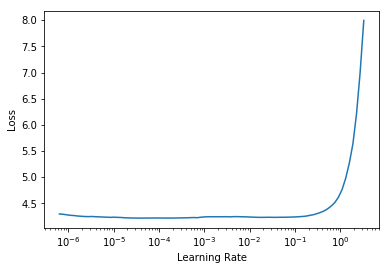

In [19]:
learn.recorder.plot()

Unfreeze and fine-tune

In [21]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(5e-3,5e-3))

Total time: 00:26
epoch  train_loss  valid_loss  accuracy
1      4.182818    4.122089    0.262376  (00:06)
2      4.029011    4.092434    0.265636  (00:06)
3      3.793159    4.077147    0.266518  (00:06)
4      3.584119    4.077979    0.267503  (00:06)



Save encoder to use for classification

In [22]:
learn.save_encoder("ft_enc_manual")

##### Train classifier

Initialize the classifier and load pretrained language model as encoder

In [27]:
learn = RNNLearner.classifier(data_clas, drop_mult=0.7)
learn.load_encoder("ft_enc_manual")

Train the classifier for a bit

In [28]:
learn.fit_one_cycle(4, 1e-4)

Total time: 01:27
epoch  train_loss  valid_loss  accuracy
1      0.791668    0.717046    0.358974  (00:22)
2      0.774663    0.693253    0.487179  (00:21)
3      0.736246    0.683241    0.589744  (00:20)
4      0.713500    0.684144    0.564103  (00:23)



In [30]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


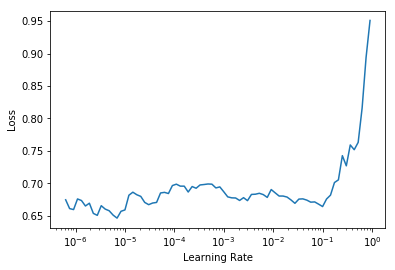

In [31]:
learn.recorder.plot()

Only train the last two layers

In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-3, 1e-2))

Total time: 01:34
epoch  train_loss  valid_loss  accuracy
1      0.627082    1.042906    0.564103  (00:23)
2      0.601831    0.822757    0.487179  (00:24)
3      0.573029    0.818868    0.487179  (00:23)
4      0.525096    0.820336    0.512821  (00:22)



In [33]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3))

Total time: 02:11
epoch  train_loss  valid_loss  accuracy
1      0.501198    0.809906    0.538462  (00:32)
2      0.456542    0.749267    0.589744  (00:31)
3      0.438998    0.820437    0.589744  (00:33)
4      0.407979    0.832557    0.589744  (00:33)



##### Cross Validation

In [2]:
FittedLearner = namedtuple("FittedLearner", [
    "learner",
    "train_perf",
    "valid_perf"
])

def fit_ensemble_fastai(path:Path, df:DataFrame, s:StratifiedShuffleSplit, **kwargs):
    """Fit a model on different subsets of the training set and collect the results
    
    Arguments:
    path - a pathlib Path pointing to the fastai working directory
    df - pandas dataframe of labels and text (no header, labels first)
    s - an object of class sklearn.model_selection.StratifiedShuffleSplit, i.e. an iterator of random, stratified splits
    **kwargs - keyword arguments to pass to the model when calling fit
    
    Returns:
    fitted_clfs - a list of fitted fastai RNNLearner objects
    """
    
    
    fitted_clfs = []
    epochs = kwargs.get("epochs", 1)

    for i, split in enumerate(s.split(df, df.iloc[:, 0])):
        i_train = split[0]
        i_valid = split[1]
        
        print("#######################################")
        print("Training model number  ", i+1)
        print("#######################################")
        print("")
        
        print("Creating language model data bunch")
        print("")
        
        fname = f"cvfold{i+1}"
        data_lm = TextLMDataBunch.from_df(path / "cv" / fname,
                                  train_df=df.iloc[i_train],
                                  valid_df=df.iloc[i_valid])
        
        print("Creating classifier data bunch")
        print("")
        
        data_clas = TextClasDataBunch.from_df(path / "cv" / fname,
                                      train_df=df.iloc[i_train],
                                      valid_df=df.iloc[i_valid],
                                      vocab=data_lm.train_ds.vocab,
                                      bs=8)
        print("Finetuning language model")
        print("")
        learn = RNNLearner.language_model(data_lm, pretrained_model=URLs.WT103, drop_mult=0.5)
        learn.fit_one_cycle(epochs, 1e-2)
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 1e-3)
        
        ename = f"ft_enc{i+1}"
        learn.save_encoder(ename)
        
        print("Training classifier")
        print("")
        learn = RNNLearner.classifier(data_clas, drop_mult=0.5)
        learn.load_encoder(ename)
        learn.fit_one_cycle(epochs, 1e-2)
        learn.freeze_to(-2)
        learn.fit_one_cycle(epochs, slice(5e-3/2., 5e-3))
        learn.unfreeze()
        learn.fit_one_cycle(epochs, slice(2e-3/100, 2e-3))
        
        train_perf = learn.validate(learn.data.train_dl)
        valid_perf = learn.recorder.metrics
        
        fitted_clfs.append(FittedLearner(learn, train_perf, valid_perf))
    
    return fitted_clfs

In [5]:
fitted_learners = fit_ensemble_fastai(path, data, s, epochs=4)

In [ ]:
fitted_learners[0].learner

Results for Model Number 1:
Train acc: [0.294403, 0.9120879120879121]
Valid acc: [[0.6410256440822895], [0.7179487210053664], [0.6666666712516394], [0.6153846184412638]]

Results for Model Number 2:
Train acc: [0.18203755, 0.9560439560439561]
Valid acc: [[0.6153846276112092], [0.6153846276112092], [0.5897436019701835], [0.564102576329158]]

Results for Model Number 3:
Train acc: [0.24366377, 0.9010989010989011]
Valid acc: [[0.6666666788932605], [0.6153846276112092], [0.6153846184412638], [0.6153846184412638]]



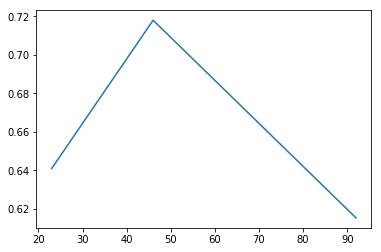

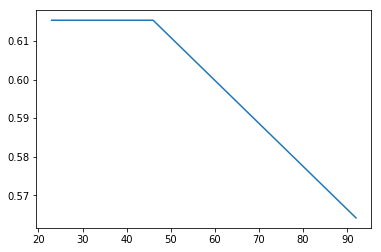

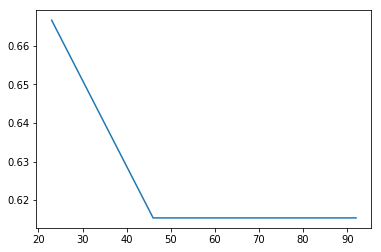

In [6]:
for i, fl in enumerate(fitted_learners):
    print(f"Results for Model Number {i+1}:")
    print(f"Train acc: {fl.train_perf}")
    print(f"Valid acc: {fl.valid_perf}")
    fl.learner.recorder.plot_metrics()
    print("")

### Archive

In [ ]:
class CustomEvaluator():
    """ Simple class holding data and functionality related to evaluating a classifier's performance
    
    """
    
    def __init__(self, texts, labels, scores):
        self.df = pd.DataFrame({"text": texts, "label": labels, "score": scores})
        self.group_means = self.df.groupby(by="label").mean()
        
    def get_scores(self, thresholds=[0.25, 0.5, 0.75]):
        if isinstance(thresholds, float):
            thresholds = [thresholds]
        
        tps = [1e-8]*len(thresholds)  # True positives
        fps = [1e-8]*len(thresholds)  # False positives
        fns = [1e-8]*len(thresholds)  # False negatives
        tns = [1e-8]*len(thresholds)  # True negatives
        
        for i, t in enumerate(thresholds):
            for truth, pred in zip(self.df["label"], self.df["score"] > t):
                if truth and pred:
                    tps[i] += 1.
                elif not truth and pred:
                    fps[i] += 1.
                elif truth and not pred:
                    fns[i] += 1.
                elif not truth and not pred:
                    tns[i] += 1.
        
        precisions = [tp / (tp + fp) for tp, fp in zip(tps, fps)]
        recalls = [tp / (tp + fn) for tp, fn in zip(tps, fns)]
        f_scores = [2 * (p * r) / (p + r) for p, r in zip(precisions, recalls)]
        accuracies = [(tp + tn) / (tp + fp + fn + tn) for tp, fp, fn, tn in zip(tps, fps, fns, tns)]
        
        score_df = pd.DataFrame({"threshold": thresholds,
                                 "precision": precisions,
                                 "recall": recalls,
                                 "f_score": f_scores,
                                 "accuracy": accuracies})
        
        print(score_df)
        self.score_df = score_df
        
        return

In [ ]:
test_evaluator = CustomEvaluator(X_text_test, y_test, test_scores)

In [ ]:
test_evaluator.group_means

In [ ]:
test_evaluator.get_scores()